<a href="https://colab.research.google.com/github/JamesRonsonOp/Complete-Python-3-Bootcamp/blob/master/03_modeling_notebooks/multi_21_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_______
# About This Notebook
_______

### This Notebook Performs Four Major Functions: 

* 1. Grid Searches Through Possible Classifiers and Hyperparameters
* 2. Fits and Scores a Multinomial Naive Bayes Classifier with Downsampled Classes
* 3. Fits and Scores a Multinomial Naive Bayes Classifier with Imbalanced Classes
* 4. Fits and Scores a Multinomial Naive Bayes Classifier with SMOTE Up-sampled Classes

### Content Links

* [Baseline Model](#baseline)
* [Downsampled Multinomial Naive Bayes](#downsampled)
* [Multinomial Naive Bayes with All Observations](#all)
* [Bootstrapped Multinomial Naive Bayes](#bootstrap)
* [Model Scoring Summary](#compiled)



_______
### Imports
______


In [159]:
import pandas as pd
import numpy as np

# Importing Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# SKLearn Libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

# SKLearn Model Libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

# SKLearn Metric Libraries
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, plot_roc_curve, auc, f1_score
from sklearn import metrics

# Other Libraries
from collections import Counter
from imblearn.over_sampling import SMOTE
from random import sample

_______
### Read in Data
_______

In [160]:
wine_df = pd.read_csv('https://raw.githubusercontent.com/JamesRonsonOp/varietal_predictor/main/data/003_preprocessed_downsampled.csv')

In [161]:
wine_df.head()

,varietal,description,color,encoded,parsed
0,Riesling,earthy hovers nettle lemon balm aromatic lemon...,white,14,earthy hovers nettle lemon balm aromatic lemon...
1,Riesling,waxy accented whiff racy footed shade invigora...,white,14,waxy accented whiff racy footed shade invigora...
2,Riesling,steep provided raimund prum offering turned mu...,white,14,steep provided raimund prum offering turned mu...
3,Riesling,closed swirling characteristic apples superrip...,white,14,closed swirling characteristic apples superrip...
4,Riesling,lend stately bursting tangerine quince brisk l...,white,14,lend stately bursting tangerine quince brisk l...


In [51]:
wine_df['parsed'][0]

'earthy hovers nettle lemon balm aromatic lemon freshness exquisitely vivid lemon freshness earthier edges adding depth unfurl passes linear incisive precise white'

In [52]:
wine_df['varietal'].value_counts()

Albarino              400
Pinot Noir            400
Pinot Grigio          400
Viognier              400
Malbec                400
Zinfandel             400
Chardonnay            400
Gruner Veltliner      400
Glera                 400
Merlot                400
Sangiovese            400
Cabernet Sauvignon    400
Sauvignon Blanc       400
Riesling              400
Chenin Blanc          400
Grenache              400
Syrah                 400
Tempranillo           400
Gewurztraminer        400
Nebbiolo              400
Garganega             244
Name: varietal, dtype: int64


__________
### Create Target and Predictor Variables
_________

In [100]:
X = wine_df['parsed']
# Creating Multi-Class Targets
y = wine_df['varietal']

In [101]:
print(f'Feature Variables Shape: {X.shape}')
print(f'Target Variables Shape: {y.shape}')

Feature Variables Shape: (8244,)
Target Variables Shape: (8244,)


<a id='baseline'></a>
____
### Baseline Model For Multi-Class Classification
____

In [102]:
y.value_counts(normalize = True)

Albarino              0.048520
Pinot Noir            0.048520
Pinot Grigio          0.048520
Viognier              0.048520
Malbec                0.048520
Zinfandel             0.048520
Chardonnay            0.048520
Gruner Veltliner      0.048520
Glera                 0.048520
Merlot                0.048520
Sangiovese            0.048520
Cabernet Sauvignon    0.048520
Sauvignon Blanc       0.048520
Riesling              0.048520
Chenin Blanc          0.048520
Grenache              0.048520
Syrah                 0.048520
Tempranillo           0.048520
Gewurztraminer        0.048520
Nebbiolo              0.048520
Garganega             0.029597
Name: varietal, dtype: float64

___
**Interpretation of the Baseline**
___
Given that all classes are balanced you would have a slightly less than 5 percent chance at blindly and randomly guessing a varietal. 
______

____
### Train / Test / Split
_____

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = .33, 
                                                   stratify = y, 
                                                   random_state = 42)

<a id='grid'></a>
_____
### Grid Searching Classifiers and Hyperparameters
_____

The code for this gridsearch was lightly adapted from here. [Github](https://github.com/opacichjj/NLP_Reddit_Classification/blob/master/3_Feature_Engineering_and_Baseline.ipynb)

In [79]:
## creating a list of our two chosen vectorizers to iterate through in our grid search
vectorizer = [CountVectorizer(), TfidfVectorizer()]

In [80]:
## creating variables to accept tuning parameters
max_feat = [1000, 2000, 5000]  
ngram_range = [(1, 1), (1, 3), (1, 2)] 
max_df = [0.9, 0.8, 1.0] 

In [59]:
## creating any empty results list to capture our cv_results_ at the end of each iteration
results = []

## looping through both vectorizers
for vect in vectorizer:
    
    #### Pipeline for our Vectorizer and Classifier Models ####
    pipeline = Pipeline([
        ('vect', vect),
        ('clf', LogisticRegression())])
    
    instantiations = [ #### Beginning of Instantiations List ####
        {
            ### Log Reg Vect Hyperparameters ###
            
            'vect__max_features': max_feat,
            'vect__ngram_range': ngram_range,
            'vect__max_df': max_df,
            
            ## Instantiate Log Reg and Hyperparamaters
            'clf': (LogisticRegression(solver='liblinear'), ), ## setting our first classifier model
            'clf__penalty': ('l1', 'l2'),
            'clf__C': (.5, 1.0), 
        }, 
    #######
        {
            
            ### Multinomial Bayes Vect Hyperparameters ###
            'vect__max_features': max_feat,
            'vect__ngram_range': ngram_range,
            'vect__max_df': max_df,
            
            ## Instantiate Mulinomial NB and Hyperparamters ##
            'clf': (MultinomialNB(), ),  
            'clf__alpha': (.5, 1.0)
        },
    #######  
        {
            ### RandomForestClassifier Vect Hyperparameters ###
            'vect__max_features': max_feat,
            'vect__ngram_range': ngram_range,
            'vect__max_df': max_df,
            
            ## Instantiate RandomForestClassifier ##
            'clf': (RandomForestClassifier(n_estimators=100, min_samples_split=3), ),
        } 
                    ] #### end of instantiations list ####
    
    
    #### Grid Search ####
    
    grid_search = GridSearchCV(pipeline, 
                               instantiations,
                               cv=3,
                               n_jobs=-1,
                               verbose=3,
                               return_train_score=True)
    
    #### Output Results ####
    
    ## running an if statement to print the type of vectorizer used
    if vect == vectorizer[0]:
        vect_string = "CountVectorizer"
    
    else:
        vect_string = "Tf-IDF Vectorizer"
    
    ## fitting our model and printing our best scores and parameters
    grid_search.fit(X_train, y_train)

    # Printing Best Score For Each Vectorizer
    print(f'''Best score for {vect_string} is: {round(grid_search.best_score_ * 100, 2)} %
    ''')
    print(grid_search.best_params_)
    print("")

# Turning the results from above into a dataframe
results_df = pd.DataFrame(grid_search.cv_results_)
# Creating a differential column to measure difference between train and test score. 
results_df['score_diff'] = results_df['mean_test_score'] - results_df['mean_train_score']

# Grouping the results based on classifier. 
results_df = results_df.sort_values('score_diff', ascending = False)
results_df['param_clf'] = results_df['param_clf'].astype(str)
results_df.groupby('param_clf').mean()

Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 252 out of 252 | elapsed:  1.6min finished


Best score for CountVectorizer is: 41.7 %
    
{'clf': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), 'clf__alpha': 1.0, 'vect__max_df': 0.9, 'vect__max_features': 2000, 'vect__ngram_range': (1, 2)}

Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 252 out of 252 | elapsed:  1.6min finished


Best score for Tf-IDF Vectorizer is: 42.02 %
    
{'clf': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), 'clf__C': 1.0, 'clf__penalty': 'l2', 'vect__max_df': 0.9, 'vect__max_features': 5000, 'vect__ngram_range': (1, 2)}



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score,score_diff
param_clf,,,,,,,,,,,,,,,,
"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=100,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=None, solver='liblinear', tol=0.0001, verbose=0,\n warm_start=False)",0.698447,0.014972,0.081698,0.004347,0.368018,0.384076,0.364815,0.372303,0.009299,42.354167,0.592335,0.588273,0.594865,0.591824,0.003601,-0.219521
"MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)",0.426689,0.010268,0.082368,0.005559,0.397746,0.414992,0.393989,0.402242,0.009452,33.500000,0.792142,0.794020,0.799792,0.795318,0.004008,-0.393076
"RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,\n criterion='gini', max_depth=None, max_features='auto',\n max_leaf_nodes=None, max_samples=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=3,\n min_weight_fraction_leaf=0.0, n_estimators=100,\n n_jobs=None, oob_score=False, random_state=None,\n verbose=0, warm_start=False)",4.368980,0.033507,0.227946,0.004969,0.364476,0.362846,0.359497,0.362273,0.003833,58.583333,0.999140,0.999479,0.999547,0.999389,0.000213,-0.637116


In [60]:
pd.DataFrame(grid_search.best_params_)

,clf,clf__C,clf__penalty,vect__max_df,vect__max_features,vect__ngram_range
0,"LogisticRegression(C=1.0, class_weight=None, d...",1.0,l2,0.9,5000,1
1,"LogisticRegression(C=1.0, class_weight=None, d...",1.0,l2,0.9,5000,2


<a id='downsampled'></a>
______
# Multinomial Naive Bayes with Downsampling and Best Parameters
_____

____
### Vectorizing MNB with Downsampling
____

In [104]:
# Instantiate CountVectorizer()
cvec = CountVectorizer(max_df = 1.0, max_features = 500, 
                       ngram_range = (1,3), stop_words = 'english')

# fit CountVectorizer()
cvec.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=500, min_df=1,
                ngram_range=(1, 3), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [105]:
# Transform the corpus on training data
X_train = cvec.transform(X_train)
X_test = cvec.transform(X_test)

____
### Fitting and Scoring MNB with Downsampling
____

In [106]:
mnb = MultinomialNB(alpha = 1.0)
mnb.fit(X_train, y_train)
train_preds = mnb.predict(X_train)
preds = mnb.predict(X_test)

In [107]:
# Testing Score
score = round(metrics.f1_score(y_test, preds, average = 'macro') * 100, 2)

# Training Score
score_train = round(metrics.f1_score(y_train, train_preds, average = 'macro') * 100, 2)

In [108]:
# Combine Training and Test Scores into a Dataframe

def score_framer( model_name_str, score_train, score_test):

    # Takes in score_train, a numeric value
    # score_test, a numeric value
    # model_name_str, create your own name of model in string format.
    
    # create a list of training and test score
    score_list = [score_train, score_test]
    # list of column headers
    key_list = ['train_score', 'test_score']
    # create a dictionary of both lists with key_list as keys
    score_dict = dict(zip(key_list, score_list))
    # create a df out of dict
    score_df = pd.DataFrame(score_dict, index = [0])
    # create model name column
    score_df['model_name'] = model_name_str
    # reorg columns
    score_df = score_df[['model_name', 'train_score', 'test_score']]
    # return df
    return score_df

f1_scores_score_mnb_down = score_framer('MNB down', score_train, score)
f1_scores_score_mnb_down

,model_name,train_score,test_score
0,MNB down,55.8,41.1


<a id='all'></a>
___
# Multinomial Naive Bayes with All Observations and Best Parameters
_____

_____
### Reading in Data without Downsampling
____

In [125]:
wine_df = pd.read_csv('https://raw.githubusercontent.com/JamesRonsonOp/varietal_predictor/main/data/003_preprocessed_all_data.csv')

In [158]:
wine_df['varietal'].value_counts(normalize = True)

Cabernet Sauvignon    0.206343
Pinot Noir            0.165533
Chardonnay            0.146336
Riesling              0.064609
Syrah                 0.062531
Sauvignon Blanc       0.061703
Merlot                0.039194
Nebbiolo              0.035216
Zinfandel             0.034266
Sangiovese            0.033343
Malbec                0.033207
Tempranillo           0.030125
Gruner Veltliner      0.016237
Pinot Grigio          0.013277
Gewurztraminer        0.012721
Viognier              0.012476
Grenache              0.008214
Glera                 0.008091
Chenin Blanc          0.007372
Albarino              0.005892
Garganega             0.003313
Name: varietal, dtype: float64

In [130]:
X = wine_df['parsed']
y = wine_df['varietal']

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = .33, 
                                                   stratify = y, 
                                                   random_state = 42)


____
### Vectorizing MNB with All Observations
____



In [132]:
# Instantiate CountVectorizer()
cvec = CountVectorizer(max_df = 1.0, max_features = 500, 
                       ngram_range = (1,3), stop_words = 'english')

# fit CountVectorizer()
cvec.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=500, min_df=1,
                ngram_range=(1, 3), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [133]:
# Transform the corpus on training data
X_train = cvec.transform(X_train)
X_test = cvec.transform(X_test)


______
### Fitting and Scoring MNB with All Observations
______


In [134]:
mnb = MultinomialNB(alpha = 1.0)
mnb.fit(X_train, y_train)
train_preds = mnb.predict(X_train)
preds = mnb.predict(X_test)

In [135]:
# Testing Score
score = round(metrics.f1_score(y_test, preds, average = 'macro') * 100, 2)

# Training Score
score_train = round(metrics.f1_score(y_train, train_preds, average = 'macro') * 100, 2)

f1_score_mnb_all = score_framer('MNB All', score_train, score)
f1_score_mnb_all

,model_name,train_score,test_score
0,MNB All,51.16,47.21


In [136]:
train_metrics = metrics.classification_report(y_train, train_preds, 
                                                 digits = 20, 
                                                 output_dict = True)
train_metrics = pd.DataFrame(train_metrics)
train_metrics


,Albarino,Cabernet Sauvignon,Chardonnay,Chenin Blanc,Garganega,Gewurztraminer,Glera,Grenache,Gruner Veltliner,Malbec,Merlot,Nebbiolo,Pinot Grigio,Pinot Noir,Riesling,Sangiovese,Sauvignon Blanc,Syrah,Tempranillo,Viognier,Zinfandel,accuracy,macro avg,weighted avg
precision,0.293750,0.731602,0.739593,0.371324,0.491525,0.544041,0.522158,0.202847,0.466281,0.521880,0.510236,0.659760,0.543624,0.725909,0.685032,0.576779,0.698666,0.529795,0.354328,0.343590,0.538198,0.643411,0.526234,0.646744
recall,0.484536,0.716586,0.809333,0.277473,0.355828,0.334395,0.679198,0.140741,0.604245,0.392923,0.335057,0.696203,0.494656,0.710981,0.729069,0.467801,0.533005,0.579067,0.616678,0.217532,0.649911,0.643411,0.515486,0.643411
f1-score,0.365759,0.724016,0.772893,0.317610,0.412811,0.414201,0.590414,0.166181,0.526373,0.448312,0.404494,0.677492,0.517986,0.718367,0.706365,0.516605,0.604694,0.553336,0.450061,0.266402,0.588803,0.643411,0.511580,0.640543
support,291.000000,10183.000000,7222.000000,364.000000,163.000000,628.000000,399.000000,405.000000,801.000000,1639.000000,1934.000000,1738.000000,655.000000,8169.000000,3189.000000,1646.000000,3045.000000,3086.000000,1487.000000,616.000000,1691.000000,0.643411,49351.000000,49351.000000


In [147]:
test_metrics = metrics.classification_report(y_test, preds, 
                                             digits = 20, 
                                             output_dict = True)

train_metrics = pd.DataFrame(train_metrics)
train_metrics

,Albarino,Cabernet Sauvignon,Chardonnay,Chenin Blanc,Garganega,Gewurztraminer,Glera,Grenache,Gruner Veltliner,Malbec,Merlot,Nebbiolo,Pinot Grigio,Pinot Noir,Riesling,Sangiovese,Sauvignon Blanc,Syrah,Tempranillo,Viognier,Zinfandel,accuracy,macro avg,weighted avg
precision,0.293750,0.731602,0.739593,0.371324,0.491525,0.544041,0.522158,0.202847,0.466281,0.521880,0.510236,0.659760,0.543624,0.725909,0.685032,0.576779,0.698666,0.529795,0.354328,0.343590,0.538198,0.643411,0.526234,0.646744
recall,0.484536,0.716586,0.809333,0.277473,0.355828,0.334395,0.679198,0.140741,0.604245,0.392923,0.335057,0.696203,0.494656,0.710981,0.729069,0.467801,0.533005,0.579067,0.616678,0.217532,0.649911,0.643411,0.515486,0.643411
f1-score,0.365759,0.724016,0.772893,0.317610,0.412811,0.414201,0.590414,0.166181,0.526373,0.448312,0.404494,0.677492,0.517986,0.718367,0.706365,0.516605,0.604694,0.553336,0.450061,0.266402,0.588803,0.643411,0.511580,0.640543
support,291.000000,10183.000000,7222.000000,364.000000,163.000000,628.000000,399.000000,405.000000,801.000000,1639.000000,1934.000000,1738.000000,655.000000,8169.000000,3189.000000,1646.000000,3045.000000,3086.000000,1487.000000,616.000000,1691.000000,0.643411,49351.000000,49351.000000


<a id='heatmap'></a>
______
#### Heatmap of Multinomial Naive Bayes

In [137]:
y_test.value_counts()

Cabernet Sauvignon    5016
Pinot Noir            4024
Chardonnay            3557
Riesling              1570
Syrah                 1520
Sauvignon Blanc       1500
Merlot                 953
Nebbiolo               856
Zinfandel              833
Sangiovese             810
Malbec                 807
Tempranillo            732
Gruner Veltliner       395
Pinot Grigio           323
Gewurztraminer         309
Viognier               303
Grenache               200
Glera                  197
Chenin Blanc           179
Albarino               143
Garganega               81
Name: varietal, dtype: int64

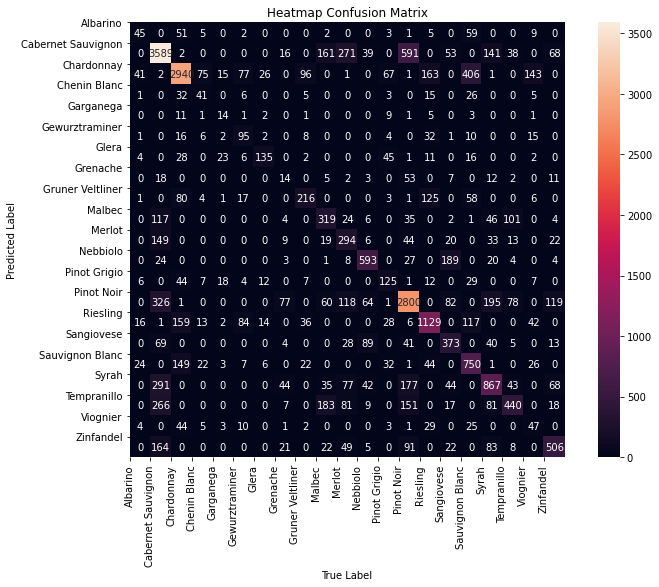

In [138]:
# Plot Heatmap of Predicted Values

varietal_labels = [
'Albarino', 'Cabernet Sauvignon', 'Chardonnay', 'Chenin Blanc', 'Garganega', 
'Gewurztraminer', 'Glera', 'Grenache', 'Gruner Veltliner', 'Malbec', 'Merlot', 'Nebbiolo', 
'Pinot Grigio', 'Pinot Noir', 'Riesling', 'Sangiovese', 'Sauvignon Blanc', 'Syrah', 
'Tempranillo', 'Viognier', 'Zinfandel'
                ]


plt.figure(figsize = (12,8))
c_matrix = confusion_matrix(y_test, preds)
sns.heatmap(c_matrix.T, square = True, annot = True, fmt = 'd', cbar = True)

plt.xticks(np.arange(21), labels = varietal_labels, rotation = 90)
plt.yticks(np.arange(21), labels = varietal_labels, rotation = 360)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Heatmap Confusion Matrix');

_____
#### Interpretation of Heatmap
_____
There are a lot of misclassifications between Pinot Noir and Cabernet. These are the largest varietals so it is expected to happen frequently among the two if the classifier is having trouble distinguising between the two of them. I am going to have to go back and analyze the feature importance in Scattertext to see if I can mitigate these issues. I may have to do some other forms of feature importance identification as well. I will follow this same process with the white wines as well. 

<a name="bootstrap"></a>

_______
# Bootstrap Imbalanced Classes
_______

## SMOTE 
______

"SMOTE stands for **Synthetic Minority Oversampling Technique.** This is a statistical technique for **increasing the number of cases in your dataset in a balanced way.** The module works by generating new instances from existing minority cases that you supply as input. This implementation of SMOTE does not change the number of majority cases.

The **new instances are not just copies** of existing minority cases; instead, the algorithm takes samples of the feature space for each target class and its nearest neighbors, and generates new examples that combine features of the target case with features of its neighbors. This approach increases the features available to each class and makes the samples more general.

**SMOTE takes the entire dataset as an input, but it increases the percentage of only the minority cases.** For example, suppose you have an imbalanced dataset where just 1% of the cases have the target value A (the minority class), and 99% of the cases have the value B. To increase the percentage of minority cases to twice the previous percentage, you would enter 200 for SMOTE percentage in the module's properties."

[Microsoft SMOTE Reference]('https://docs.microsoft.com/en-us/azure/machine-learning/studio-module-reference/smote#:~:text=SMOTE%20stands%20for%20Synthetic%20Minority,dataset%20in%20a%20balanced%20way.&text=SMOTE%20takes%20the%20entire%20dataset,of%20only%20the%20minority%20cases.')

______________

In [139]:
def smote_oversample(x, y):

    # Instantiate Oversampler
    oversample = SMOTE()
    
    # fit oversampler
    x, y = oversample.fit_resample(x, y)
    
    # Counter creates a dict that summarizes the distribution
    counter = Counter(y)

    for key, value in counter.items():
        
        # create variable with percentage of samples of each variable 
        percent = round(value / len(y) * 100, 2)
        
    # create df of target labels
    ovr_sampled = pd.DataFrame(counter.keys(), columns = ['target_label'])
    # append number of samples to df
    ovr_sampled['num_samples'] = counter.values()
    # append percentage of samples to df
    ovr_sampled['percent'] = percent

    plt.bar(ovr_sampled['target_label'], ovr_sampled['percent'])
    
    plt.title('Class Labels as Percentage of Samples')
    plt.xlabel('Class')
    plt.ylabel('Percentage of Labels')
    plt.xticks(rotation = 90)
    plt.show(); 
    
    # return df of sample distributions
    print(ovr_sampled)
    
    return x, y

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


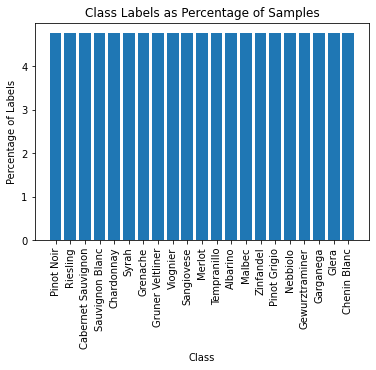

          target_label  num_samples  percent
0           Pinot Noir        10183     4.76
1             Riesling        10183     4.76
2   Cabernet Sauvignon        10183     4.76
3      Sauvignon Blanc        10183     4.76
4           Chardonnay        10183     4.76
5                Syrah        10183     4.76
6             Grenache        10183     4.76
7     Gruner Veltliner        10183     4.76
8             Viognier        10183     4.76
9           Sangiovese        10183     4.76
10              Merlot        10183     4.76
11         Tempranillo        10183     4.76
12            Albarino        10183     4.76
13              Malbec        10183     4.76
14           Zinfandel        10183     4.76
15        Pinot Grigio        10183     4.76
16            Nebbiolo        10183     4.76
17      Gewurztraminer        10183     4.76
18           Garganega        10183     4.76
19               Glera        10183     4.76
20        Chenin Blanc        10183     4.76


In [140]:
XS_train, ys_train = smote_oversample(X_train, y_train)

______
### Fitting and Scoring MNB with SMOTE Applied
______

In [150]:
smote_mnb = MultinomialNB(alpha = 1.0)
smote_mnb.fit(XS_train, ys_train)
smote_train_preds = smote_mnb.predict(XS_train)
smote_preds = smote_mnb.predict(X_test)

In [152]:
# Testing Score
score = round(metrics.f1_score(y_test, smote_preds, average = 'macro') * 100, 2)

# Training Score
score_train = round(metrics.f1_score(ys_train, smote_train_preds, average = 'macro') * 100, 2)

f1_score_smote = score_framer('MNB SMOTE', score_train, score)
f1_score_smote

,model_name,train_score,test_score
0,MNB SMOTE,51.53,45.75


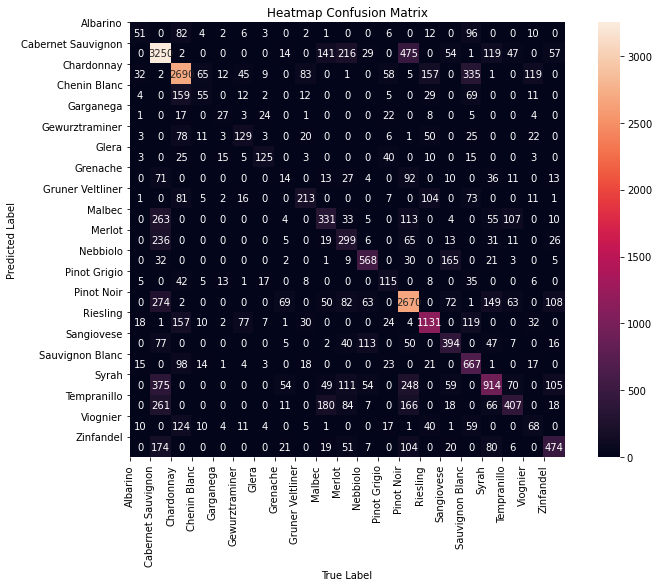

In [155]:
varietal_labels = [
'Albarino', 'Cabernet Sauvignon', 'Chardonnay', 'Chenin Blanc', 'Garganega', 
'Gewurztraminer', 'Glera', 'Grenache', 'Gruner Veltliner', 'Malbec', 'Merlot', 'Nebbiolo', 
'Pinot Grigio', 'Pinot Noir', 'Riesling', 'Sangiovese', 'Sauvignon Blanc', 'Syrah', 
'Tempranillo', 'Viognier', 'Zinfandel'
                ]


plt.figure(figsize = (12,8))
c_matrix = confusion_matrix(y_test, smote_preds)
sns.heatmap(c_matrix.T, square = True, annot = True, fmt = 'd', cbar = True)

plt.xticks(np.arange(21), labels = varietal_labels, rotation = 90)
plt.yticks(np.arange(21), labels = varietal_labels, rotation = 360)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Heatmap Confusion Matrix');

<a name="compiled"></a>
____
# Compiling All Model F1 Scores
_____

In [157]:
f1_df = pd.concat([f1_scores_score_mnb_down, f1_score_mnb_all, f1_score_smote])
f1_df['tt_diff'] = f1_df['train_score'] - f1_df['test_score']
f1_df.reset_index(drop = True, inplace = True)
f1_df

,model_name,train_score,test_score,tt_diff
0,MNB down,55.80,41.10,14.70
1,MNB All,51.16,47.21,3.95
2,MNB SMOTE,51.53,45.75,5.78


**Analysis of F1 Scores**

These scores were drastically different prior to my final presentation so they are reflected differently in the slides. In this case the Downsampled version scored 58.5 training and 38.79 in the testing. It scored better in this instance. In the imbalanced or 'all' dataset the model was performing better initially at 50.76 train and 49.23 test. 